# Some functions to calculate gs_model and plots

In [1]:
from lmfit import Model, Parameters, Parameter
import numpy as np
import pandas as pd
from atmosp import calculate as ac
import numpy as np
from scipy.optimize import minimize
from pathlib import Path
import supy as sp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
import random
import pickle
import os
from shutil import copyfile
from IPython.display import clear_output
from gs_util import (read_forcing,modify_attr,cal_gs_obs,
                     IQR_compare,obs_sim,cal_gs_mod,gs_plot_test,
                     modify_attr_2,func_parse_date,run_LAI_states)

# Preparing the data (obs and model)

In [2]:
name='CA-Obs' 
year=2008
df_forcing= read_forcing(name,year)

In [3]:
path_runcontrol = Path('runs/run'+'/') / 'RunControl.nml'
df_state_init = sp.init_supy(path_runcontrol)
df_state_init,level=modify_attr(df_state_init,name)
df_state_init.loc[:,'soilstore_id']=[50,50,50,50,50,50,0]


grid = df_state_init.index[0]
df_forcing_run = sp.load_forcing_grid(path_runcontrol, grid)
df_output, df_state_final = sp.run_supy(df_forcing_run, df_state_init, save_state=False)
df_forcing_run.lai=df_output.SUEWS.loc[grid,:].LAI


with open('./outputs/roughness/all_periods_train.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


error=10
for i in range(10):
    if (error <= 0.1):
        break
    clear_output()
    df_state_final,all_LAI_output=run_LAI_states(grid,z0f,zdf,df_forcing_run,
                                                 df_state_init,name,
                                                 year,doy_LAI,
                                                 path_runcontrol)
    final_state = df_state_final[df_state_init.columns.levels[0]].iloc[1]
    df_state_init.iloc[0] = final_state
    soilstore_before = df_state_final.soilstore_id.iloc[0]
    soilstore_after = df_state_final.soilstore_id.iloc[1]
    diff_soil = sum(abs(soilstore_after-soilstore_before))
    error = 100*diff_soil/soilstore_before.mean()
    print(error)


2008-01-01 00:00:00 2008-04-14 00:00:00
2020-05-01 11:45:35,878 — SuPy — INFO — ====================
2020-05-01 11:45:35,881 — SuPy — INFO — Simulation period:
2020-05-01 11:45:35,884 — SuPy — INFO —   Start: 2008-01-01 00:00:00
2020-05-01 11:45:35,886 — SuPy — INFO —   End: 2008-04-14 00:00:00
2020-05-01 11:45:35,887 — SuPy — INFO — 
2020-05-01 11:45:35,890 — SuPy — INFO — No. of grids: 1
2020-05-01 11:45:35,900 — SuPy — INFO — SuPy is running in serial mode
2020-05-01 11:45:38,744 — SuPy — INFO — Execution time: 2.9 s
2020-05-01 11:45:38,745 — SuPy — INFO — ====================

2008-04-15 00:00:00 2008-06-16 00:00:00
2020-05-01 11:45:38,759 — SuPy — INFO — ====================
2020-05-01 11:45:38,760 — SuPy — INFO — Simulation period:
2020-05-01 11:45:38,760 — SuPy — INFO —   Start: 2008-04-15 00:00:00
2020-05-01 11:45:38,762 — SuPy — INFO —   End: 2008-06-16 00:00:00
2020-05-01 11:45:38,762 — SuPy — INFO — 
2020-05-01 11:45:38,764 — SuPy — INFO — No. of grids: 1
2020-05-01 11:45:38

In [4]:
df=all_LAI_output.resample('1h',closed='left',label='right').mean()

In [5]:
df_forcing.xsmd=df.SMD
df_forcing.lai=df.LAI
df_forcing = df_forcing[df_forcing.qe > 0]
df_forcing = df_forcing[df_forcing.qh > 0]
df_forcing = df_forcing[df_forcing.kdown > 5]
df_forcing = df_forcing[df_forcing.Tair > -20]
df_forcing.pres *= 1000
df_forcing.Tair += 273.15
gs_obs = cal_gs_obs(df_forcing.qh, df_forcing.qe, df_forcing.Tair,
                        df_forcing.RH, df_forcing.pres,df.RA)
df_forcing=df_forcing[gs_obs>0]
gs_obs=gs_obs[gs_obs>0]
df_forcing=df_forcing.replace(-999,np.nan)

In [6]:
g_max=np.percentile(gs_obs,99)
s1=5.56

In [7]:
print('g_max is {}'.format(g_max))

g_max is 91.46368317811394


In [8]:
df_forcing=df_forcing[gs_obs<g_max]
lai_max=df_state_init.laimax.loc[grid,:][0]
gs_obs=gs_obs[gs_obs<g_max]


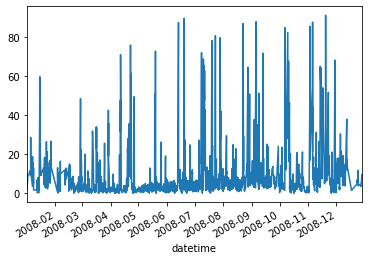

In [9]:
gs_obs.plot()

In [10]:
print('lai_max is {}'.format(lai_max))

lai_max is 2.5


# Splitting the data to test and train

In [11]:
df_forcing_train, df_forcing_test, gs_train, gs_test = train_test_split(df_forcing, gs_obs, test_size=0.6, random_state=42)

In [12]:
kd=df_forcing_train.kdown
ta=df_forcing_train.Tair
rh=df_forcing_train.RH
pa=df_forcing_train.pres
smd=df_forcing_train.xsmd
lai=df_forcing_train.lai

# Optimization

## More info in [here](https://platypus.readthedocs.io/en/latest/getting-started.html#)

In [13]:
def fun_to_opts(G):
    [g1,g2, g3, g4, g5, g6]=[G[0],G[1],G[2],G[3],G[4],G[5]]
    gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_z=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)
    gs_obs=gs_train
    o1=abs(1-np.std(gs_model)/np.std(gs_obs)) # normilized std difference
    o2=np.mean(abs(gs_model-gs_obs))/(np.mean(gs_obs))
    return [o1,o2],[gs_model.min()]

In [14]:
problem = Problem(6,2,1)
problem.types[0] = Real(.05, .5)
problem.types[1] = Real(100, 500)
problem.types[2] = Real(0, 1)
problem.types[3] = Real(0.4, 1)
problem.types[4] = Real(25, 55)
problem.types[5] = Real(0.02, 0.03)

problem.constraints[0] = ">=0"

problem.function = fun_to_opts
random.seed(12345)
algorithm=CMAES(problem, epsilons=[0.005])
#algorithm=NSGAIII(problem, divisions_outer=12)
algorithm.run(3000)


In [15]:
print( " Obj1\t Obj2")

for solution in algorithm.result[:10]:
    print ("%0.3f\t%0.3f" % tuple(solution.objectives))

 Obj1	 Obj2
0.048	1.481
0.245	1.234
0.348	1.113
0.365	1.095
0.283	1.188
0.254	1.223
0.678	0.808
0.414	1.039
0.533	0.919
0.125	1.382


## It shows how two objective changes

Text(0, 0.5, 'objective 2')

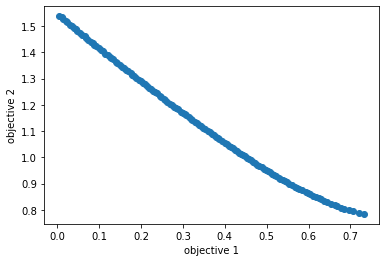

In [16]:
f, ax = plt.subplots(1, 1)
plt.scatter([s.objectives[0] for s in algorithm.result],
           [s.objectives[1] for s in algorithm.result])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

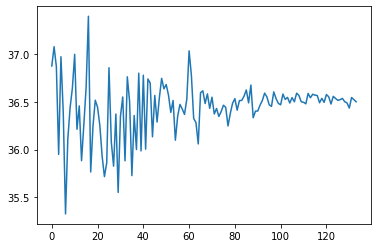

In [17]:
all_G={
      'g2':[],
      'g3':[],
      'g4':[],
      'g5':[],
      'g6':[]
      }
for s in algorithm.result:
        all_G['g2'].append(s.variables[0])
        all_G['g3'].append(s.variables[1])
        all_G['g4'].append(s.variables[2])
        all_G['g5'].append(s.variables[3])
        all_G['g6'].append(s.variables[4])
plt.plot(all_G['g6'])

In [18]:
all_std=[s.objectives[0] for s in algorithm.result]
all_MAE=[s.objectives[1] for s in algorithm.result]
all_std=np.array(all_std)
all_MAE=np.array(all_MAE)

## Choosing between : the median of two objectives, where obj1 is max or where obj2 is max

In [19]:
method='median' # 'obj1' or 'obj2' or 'median'
colors= ['b','g','r','y']

if method == 'median':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.median(all_std))].min())[0][0]
elif method == 'obj1':
    idx_med=np.where(all_MAE==all_MAE[(all_std>=np.min(all_std))].max())[0][0]
elif method == 'obj2':
    idx_med=np.where(all_MAE==all_MAE[(all_std<=np.max(all_std))].min())[0][0]
print(all_std[idx_med])
print(all_MAE[idx_med])


0.3337984868655277
1.129260788946374


In [20]:
[g1,g2,g3,g4,g5,g6] = algorithm.result[idx_med].variables

In [21]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','wb') as f:
    pickle.dump([g1,g2,g3,g4,g5,g6], f)

In [22]:
with open('outputs/g1-g6/'+name+'-g1-g6.pkl','rb') as f:
    [g1,g2,g3,g4,g5,g6]=pickle.load(f)

In [23]:

pd.DataFrame([np.round([g1,g2,g3,g4,g5,g6],3)],columns=['g1','g2','g3','g4','g5','g6'],index=[name])

,g1,g2,g3,g4,g5,g6
CA-Obs,0.286,104.646,0.702,0.632,36.623,0.022


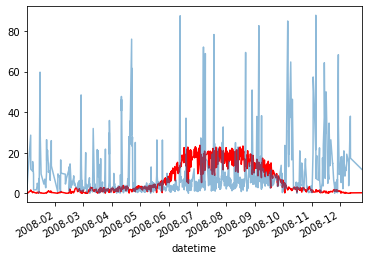

In [24]:
gs_model,g_lai,g_kd,g_dq,g_ta,g_smd,g_max=cal_gs_mod(kd, ta, rh, pa, smd, lai,
                          [g1, g2, g3, g4, g5, g6],
                          g_max, lai_max, s1)

gs_model.plot(color='r')
gs_train.plot(alpha=0.5)

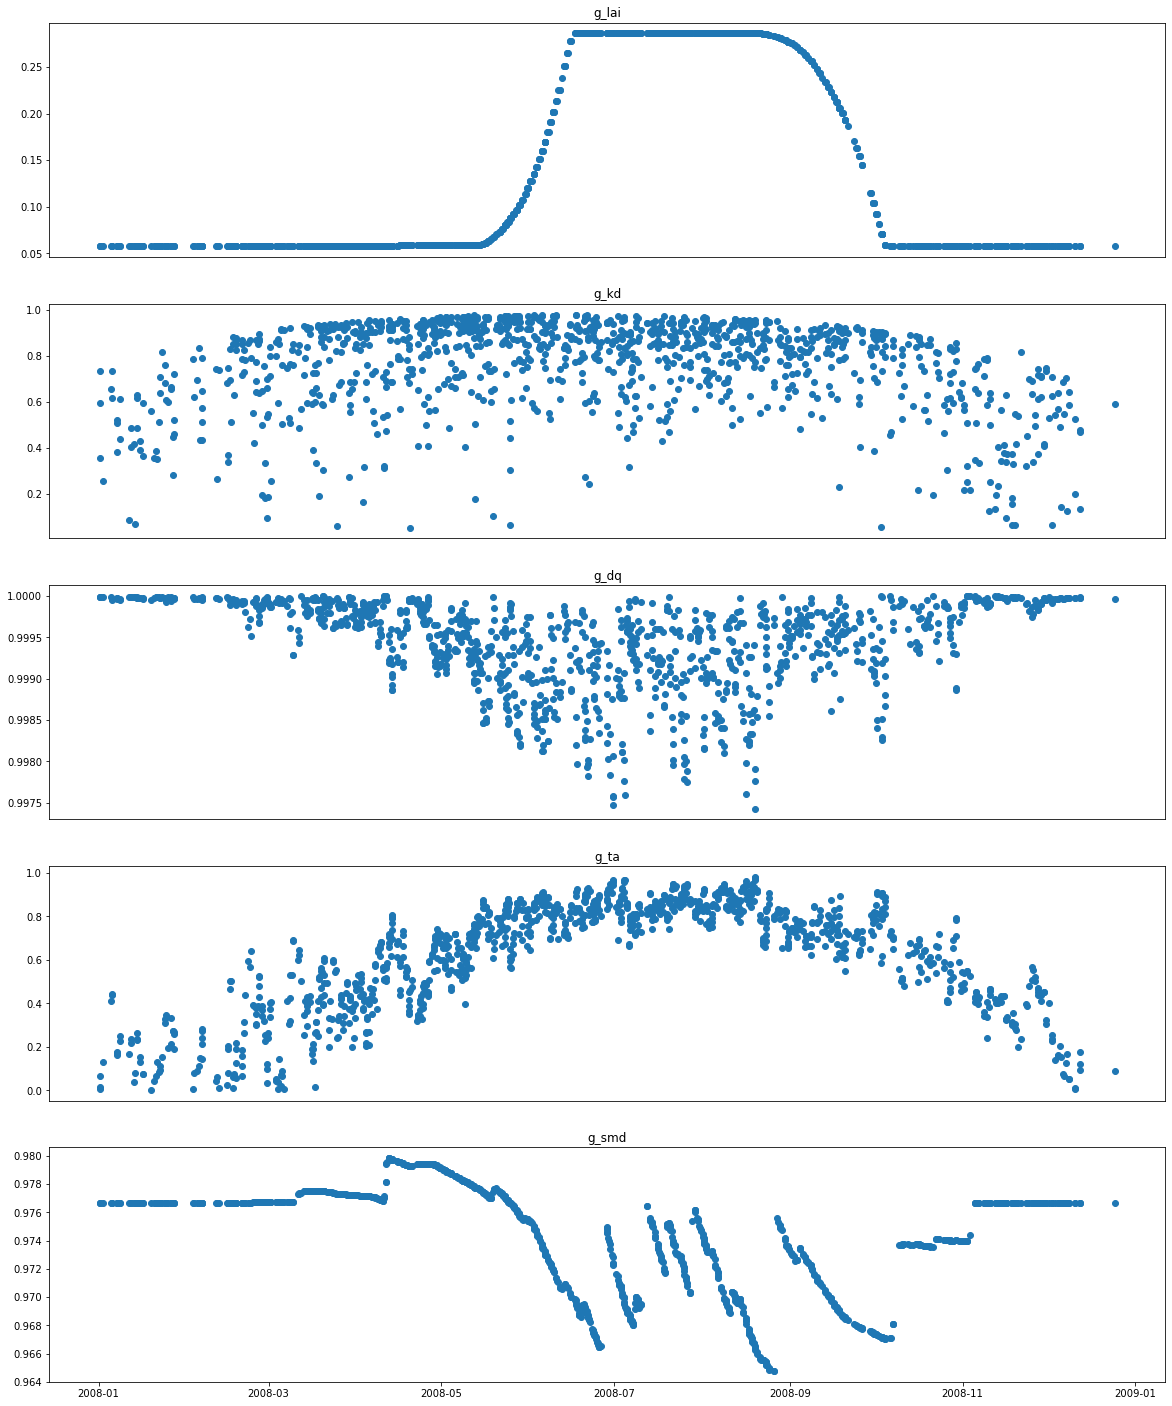

In [25]:
g_dq=pd.DataFrame(g_dq,index=g_lai.index)
fig,axs=plt.subplots(5,1,figsize=(20,25))
a={'0':g_lai,'1':g_kd,'2':g_dq,'3':g_ta,'4':g_smd}
b={'0':'g_lai','1':'g_kd','2':'g_dq','3':'g_ta','4':'g_smd'}
for i in range(0,5):
    ax=axs[i]
    #a[str(i)].plot(ax=ax)
    ax.scatter(a[str(i)].index,a[str(i)])
    ax.set_title(b[str(i)])
    if i!=4:
        ax.set_xticks([''])
        ax.set_xlabel('')

## Running Supy with new g1-g6

/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


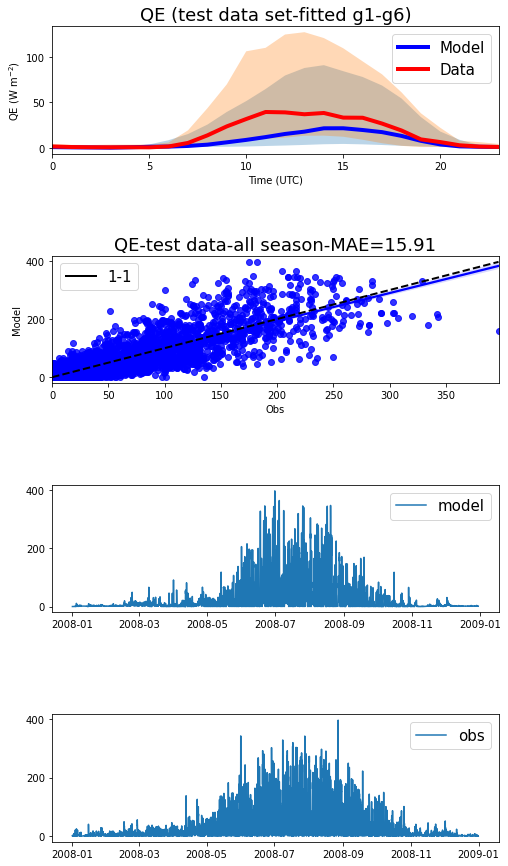

In [26]:
alpha=.57
name='CA-Obs'
year=year


with open('./outputs/roughness/all_periods_train.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]

gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI,alpha)

In [27]:
g1=g1*alpha
g_max=g1*g_max
g1=1


In [28]:
g_max

14.9134744593889

# Creating the table for all sites here

In [29]:
sites=['CA-Obs']
g1_g6_all=pd.DataFrame(columns=['g1','g2','g3','g4','g5','g6'])

for s in sites:
    with open('outputs/g1-g6/'+s+'-g1-g6.pkl','rb') as f:
        g1_g6_all.loc[s,:]=pickle.load(f)
g1_g6_all  

,g1,g2,g3,g4,g5,g6
CA-Obs,0.286059,104.646,0.702473,0.631525,36.6235,0.021617


# To test

## CA-Obs-2006

/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


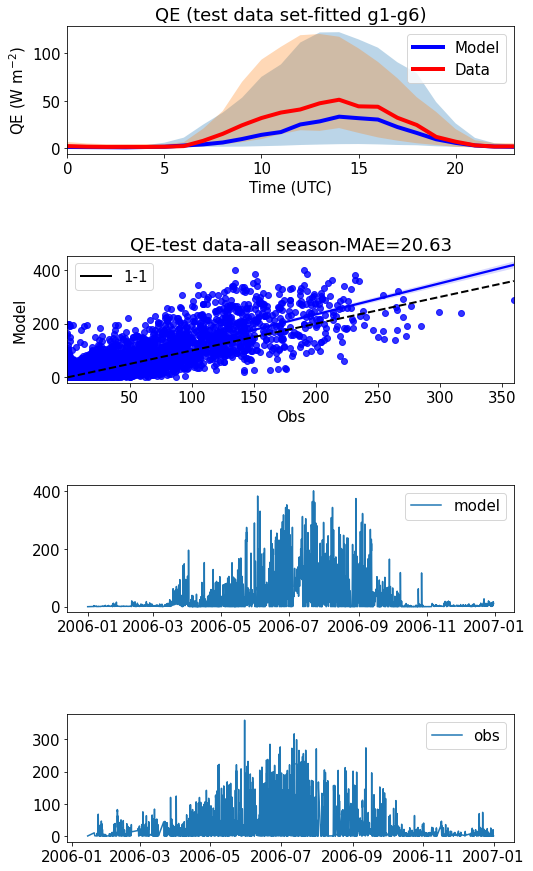

In [30]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56


name='CA-Obs'
year=2006
df_forcing= read_forcing(name,year)

with open('./outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)

## US-Blk-2006

/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


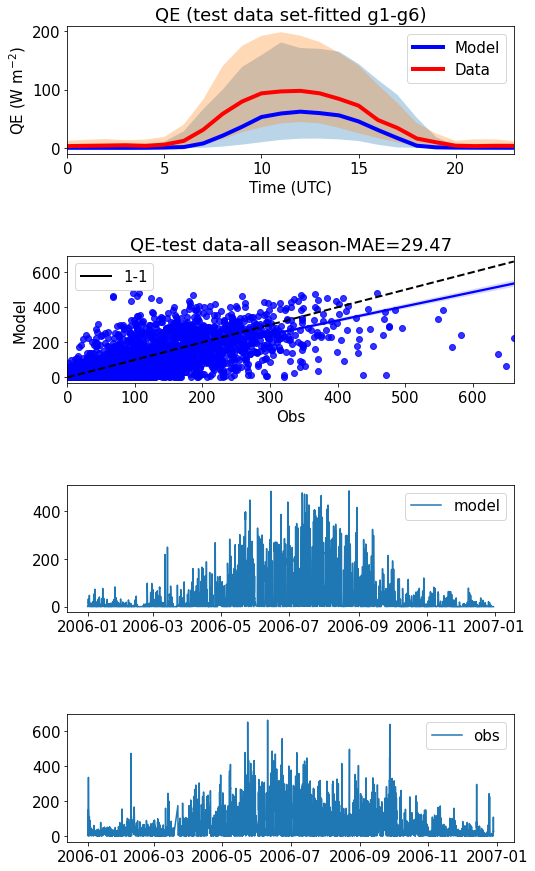

In [31]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='US-Blk'
year=2006
df_forcing= read_forcing(name,year)

with open('./outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)

## CA-Qcu-2005

/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/hamidrezaomidvar/anaconda3/envs/SUEWS_parameters/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


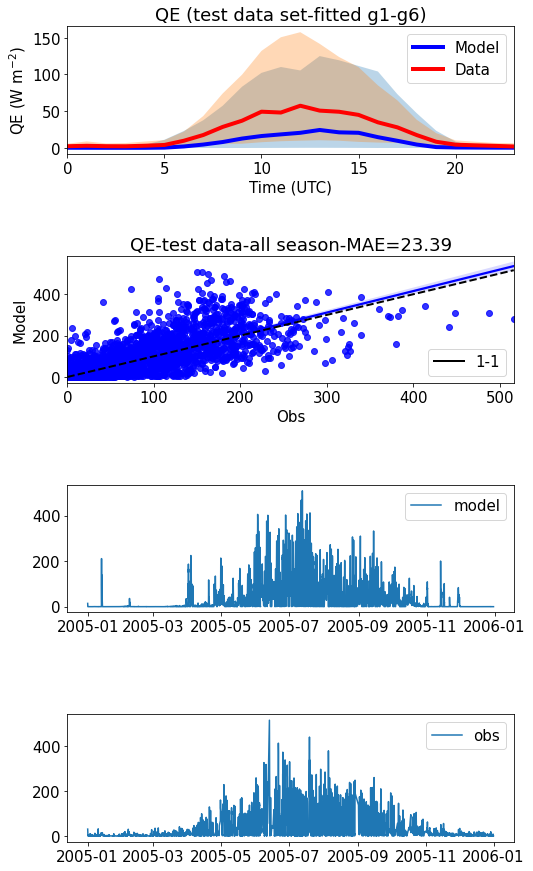

In [32]:
g1,g2,g3,g4,g5,g6=g1_g6_all.loc['CA-Obs',:].values
g_max=g_max
g1=1
s1=5.56

name='CA-Qcu'
year=2005
df_forcing= read_forcing(name,year)

with open('./outputs/roughness/all_periods_test.pkl','rb') as f:
    all_periods=pickle.load(f)
z0f=[0.16,0.18,0.18,0.18,0.16]
zdf=[0.5,0.44,0.42,0.44,0.5] 
doy_LAI=all_periods[name][year]


gs_plot_test(g1,g2,g3,g4,g5,g6,g_max,s1,name,year,z0f,zdf,doy_LAI)